In [ ]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation


## Example: Money laundering via fictitious company turnover

*Overview*
  *  What is money laundering, and why people do it? (in presentation)
  *  Various form of economic-based money laundering (in presentation)
  *  Aim and description of our exersize
  *  A closer look on fictious turnover
  *  Supervised anomaly detection (in presentation)
  *  Building your own detection pipeline
  *  On interpretability of ML models: decision trees

### Aim and description of our exersize

In this example, we will look at a specific real-world case of money laundering:

> A person involved in cannabis cultivation started a taxi company with 12 taxis with the aim of laundering the criminal proceeds. Private loans and turnover were falsified via the company. The stated turnover did not correspond with the data recorded by the taximeters.

source: [Dutch National Risk Assessment on Money
Laundering 2019](https://repository.wodc.nl/bitstream/handle/20.500.12832/249/Cahier_2020-11a_Full_text_2689h_tcm28-470222.pdf?sequence=6&isAllowed=y)

In this **specific case** we can utilize *supervised anomaly detection*


### Data

We use real world data of taxi rides: [source](https://www.kaggle.com/datasets/mickhirsh/taxi-data-set/)

In [ ]:
!kaggle datasets download mickhirsh/taxi-data-set
!unzip taxi-data-set.zip

Dataset URL: https://www.kaggle.com/datasets/mickhirsh/taxi-data-set
License(s): unknown
  0% 0.00/5.40M [00:00<?, ?B/s]
100% 5.40M/5.40M [00:00<00:00, 97.5MB/s]
Archive:  taxi-data-set.zip
  inflating: Taxi_Set.csv            


In [ ]:
df_taxi = pd.read_csv("Taxi_Set.csv")


df_taxi['driver_id'] = random.choices(['mary','joe','sue'], k=df_taxi.shape[0])
df_taxi['true_label'] = 0

#fare_w_flag = 2.70 + wait_time_cost + distance_cost
#total_fare_new = miscellaneous_fees + tip + fare_w_flag
#surge applied taxi = increasing the price with higher demand
print(df_taxi.shape)
df_taxi.head(10)

(207596, 15)


,trip_duration_sec,trip_duration_min,trip_duration_hr,distance_traveled_Km,KPH,wait_time_cost,distance_cost,fare_w_flag,tip,miscellaneous_fees,total_fare_new,num_of_passengers,surge_applied,driver_id,true_label
0,748,12.47,0.207833,2.75,13.231756,4.97,4.27,11.94,24,6.30,42.24,1,False,mary,0
1,1187,19.78,0.329667,3.43,10.404449,7.89,5.33,15.92,24,13.20,53.12,1,False,sue,0
2,730,12.17,0.202833,3.12,15.382087,4.85,4.85,12.40,0,26.63,39.03,1,True,mary,0
3,671,11.18,0.186333,5.63,30.214669,4.46,8.75,15.91,0,9.75,25.66,3,False,joe,0
4,329,5.48,0.091300,2.09,22.883212,2.19,3.25,8.14,12,13.20,33.34,1,False,mary,0
5,355,5.92,0.098700,1.74,17.635135,2.36,2.70,7.76,0,26.63,34.39,1,True,sue,0
6,453,7.55,0.125833,2.22,17.642384,3.01,3.45,9.16,0,6.00,15.16,1,False,sue,0
7,1288,21.47,0.357833,5.21,14.559851,8.56,8.09,19.35,36,26.33,81.68,1,True,mary,0
8,134,2.23,0.037200,1.48,39.820628,0.89,2.30,5.89,0,6.00,11.89,1,False,mary,0
9,980,16.33,0.272167,3.48,12.786283,6.52,5.41,14.63,0,6.00,20.63,1,False,joe,0


array([[<Axes: title={'center': 'trip_duration_sec'}>,
        <Axes: title={'center': 'distance_traveled_Km'}>,
        <Axes: title={'center': 'tip'}>],
       [<Axes: title={'center': 'fare_w_flag'}>,
        <Axes: title={'center': 'miscellaneous_fees'}>,
        <Axes: title={'center': 'total_fare_new'}>]], dtype=object)

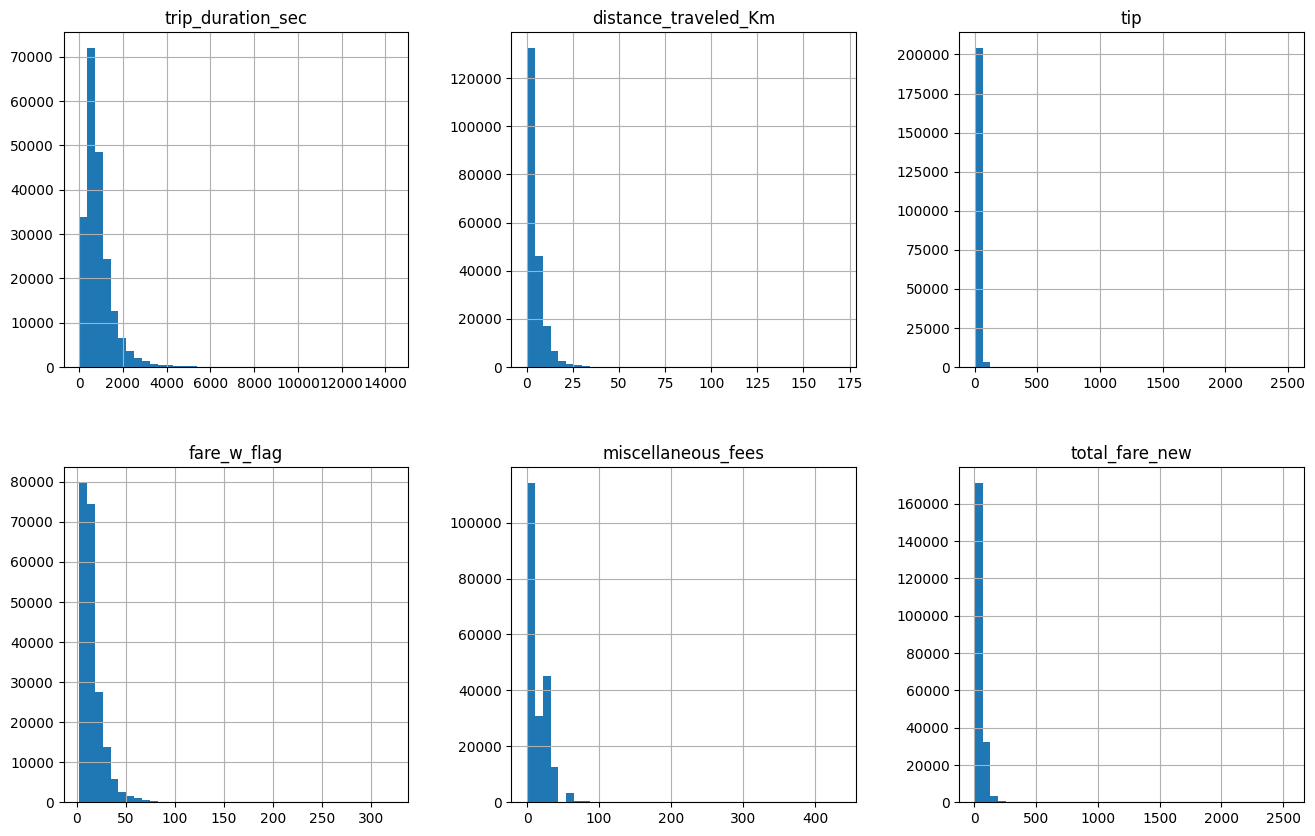

In [ ]:
df_taxi.hist(['trip_duration_sec', 'distance_traveled_Km', 'tip', 'fare_w_flag','miscellaneous_fees','total_fare_new'], bins = 40, figsize = (16,10), layout = (2,3))

#### generate misreported data

In [ ]:
#let us generate behavior of a money laundering driver
# Shady Bob is reporting false data!

def money_laudnering_driver(df_taxi, nr_rides = 50000):
  #shady bob samples honest reports
  df = df_taxi.sample(n=nr_rides, replace = True, random_state=2025)
  df['driver_id'] = ['shady bob'] * df.shape[0]
  df['true_label'] = 1
  #adds some small amount of money that he wants to legalize, which will be some percentage of the real fee
  fictious_fee_percent = random.uniform(0.1,0.2)
  #Shady Bob is not very smart, so he will add it to the distance cost (no knowing that's something we can compare with km)
  df['distance_cost'] = df['distance_cost'] * (1 + fictious_fee_percent)
  #bob recalculates the new price
  df['fare_w_flag'] = 2.70 + df['wait_time_cost'] + df['distance_cost']
  df['total_fare_new'] = df['miscellaneous_fees'] + df['tip'] + df['fare_w_flag']

  return df


df_fraudulent = money_laudnering_driver(df_taxi)

### Supervised detection using decision trees






In [ ]:
df = pd.concat([df_taxi, df_fraudulent])
y = df['true_label'].to_list()

#we drop columns that wont be used for clustering
del df['trip_duration_min']
del df['trip_duration_hr']
del df['KPH']
del df['num_of_passengers']
del df['driver_id']
del df['true_label']

#we map bool column to int
df['surge_applied'] = df['surge_applied'].astype(int)

#we perform z-score transformation on each column except the surge_applied column
for column in df.columns.drop('surge_applied'):
    df[column] = (df[column] - df[column].mean()) / df[column].std()

# view normalized data
df.head(5)

,trip_duration_sec,distance_traveled_Km,wait_time_cost,distance_cost,fare_w_flag,tip,miscellaneous_fees,total_fare_new,surge_applied
0,-0.186048,-0.411619,-0.186815,-0.424592,-0.357912,0.545248,-0.709896,-0.061518,0
1,0.465554,-0.271337,0.465036,-0.287585,-0.012316,0.545248,-0.158436,0.263474,0
2,-0.212766,-0.335289,-0.213603,-0.349626,-0.317969,-0.650390,0.914912,-0.157403,1
3,-0.300339,0.182515,-0.300665,0.154457,-0.013185,-0.650390,-0.434166,-0.556773,0
4,-0.807965,-0.547775,-0.807412,-0.556429,-0.687878,-0.052571,-0.158436,-0.327366,0


In [ ]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth = 5, max_leaf_nodes=20)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.851460293223256


### Interpretability of results

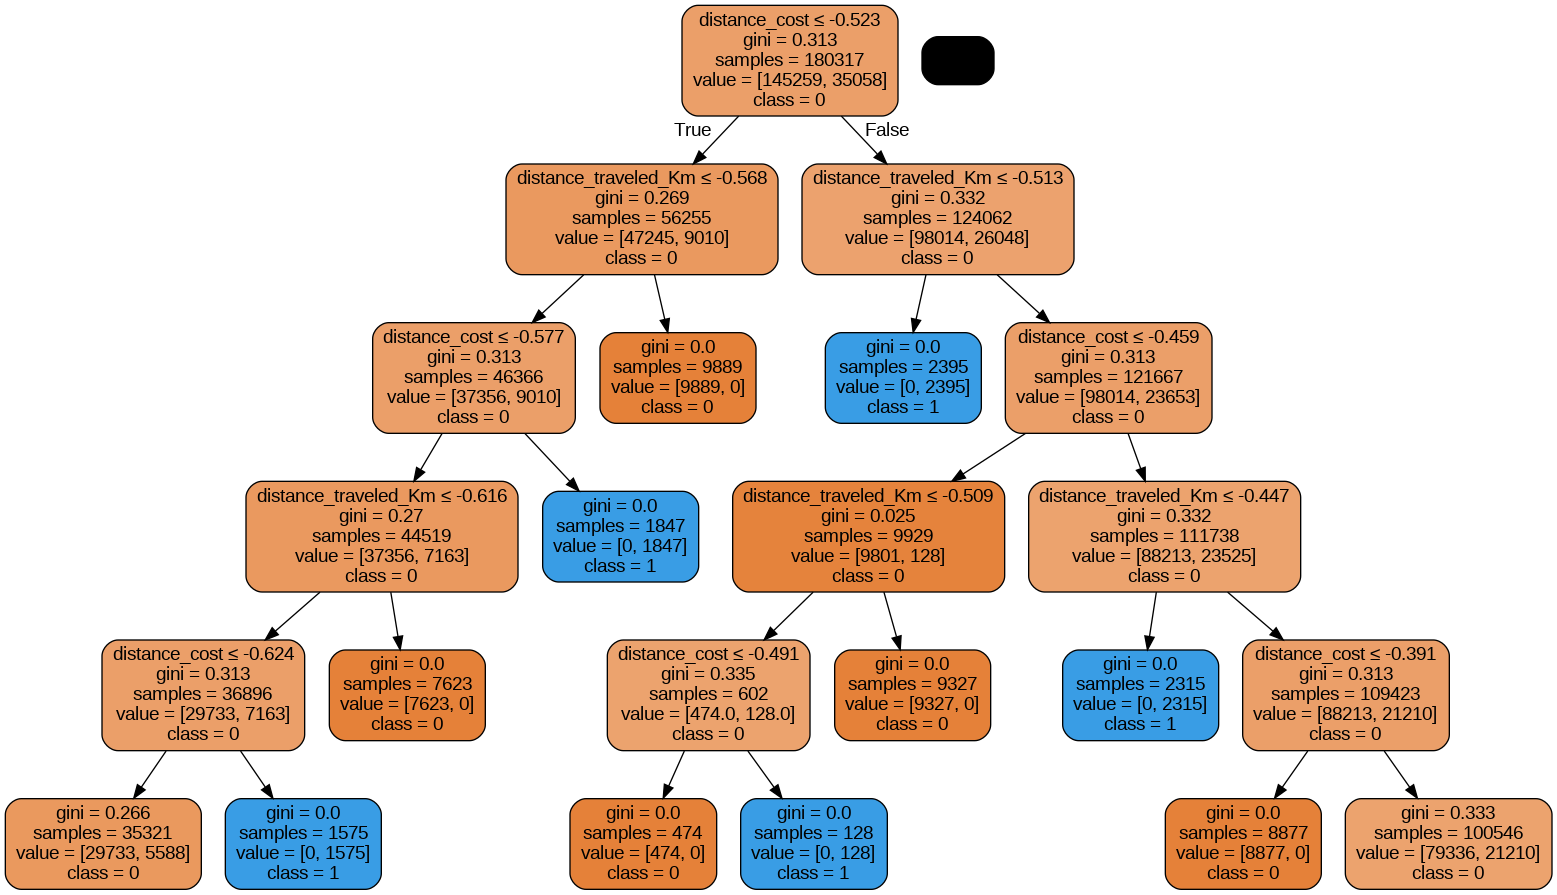

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

#TODO: inverse z-score of the values for better interpretability

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names = df.columns.to_list(), class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('decision tree.png')
Image(graph.create_png())


As we can see on the graph above, distance travelled is the main variable. This can be also investigated explicitly by ...

In [ ]:
#todo: add bar graph about predictibility

#### Utility of noncomplinace

*  Each non-compliance is done because it generates profits.
*  Thereofre, we do not need to catch every criminal. We only need to catch the ones that make the most money, and eridicate non-compliance economically by (1) developing advanced technology, and (2) optimizing our resource allocation


In [ ]:
#here, calculate how much money the taxi driver generates

#### Exesize:

modify data generating function above such that:
1. you avoid being detected by our detection model as much as possible
2. you won't sacrifice profit

In [ ]:
#here, write a signature for the function with some minimal code and comments where to and what to add by students